# Chapter 2. Neural Modeling and Analysis

* 2.1 Biophysical neuron models: 
    - HH model, IaF model, alpha function
* 2.2 Abstract neuron models: f-I curve, sigmoid, MP neuron  
* 2.3 Models of plasticity: Hebb rule, STDP  
* 2.4 Theories of neural coding: rate, population, coincidence, synchrony, waves  
* 2.5 Methods of neural decoding: PESH, PESC, STA, STC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import odeint, ode

## 2.1 Biophysical neuron models

Among variety of cells that compose animal body, what is striking about neurons is their complex shapes: branches of dendrites and long-projecting axons. 
For example, check [NeuroMorpho.org](http://neuromorpho.org) for 3D morphological data of thousansa of neurons.
There are non-neural cells that show electric activities and chemical signaling, but neurons are specialized for collecting signals from thousands of different neurons and sending the output to target neurons far apart. 

Here we introduce basic mathematical models that capture biophysical properties of neurons, namely, electirc excitation, synaptic transmission, and dendritic integtion.

### Hodgkin-Huxley neuron models
The Hodgkin-Huxley (HH) model considers a neuron as an electric circuit as depicted below.
![HH model](figures/hhmodel.jpg)

On the cellular membrane, there are *ionic channels* that pass specific type of ions. Sodium ions (Na$^+$) are scarce inside the cell, so that when sodium channel opens, positive charges flood into the cell to cause excitation. Potassium ions (K$^+$) are rich inside the cell, so that when potassium channel opens, positive charges flood out of the cell to cause inhibition. The HH model assumes a 'leak' current that put together all other ionic currents.

The ingeniety of Hodgkin and Huxley is that they inferred from careful data analysis that a single sodium channel consists of three *activation* gates and one *inactivation* gate, and a single potassium channel consists of four activation gates. Such structures were later confirmed by genomics and imaging.

The electric potential inside the neuron $V$ follows the following equation:

$$C \frac{dV}{dt} = g_{Na}m^3h(E_{Na}-V) + g_Kn^4(E_K-V) + g_L(E_L-V) + I$$

Here, $m$, $h$, and $n$ represent the proportions of opening of sodium activation, sodium inactivation, and potassium activation gates, respectively. 
They follow the following differential equations with their rates of opening and closing, $\alpha(V)$ and $\beta(V)$, depending on the membrane voltage $V$.

$$\frac{dm}{dt} = \alpha_m(V)(1-m) - \beta_m(V)m$$

$$\frac{dh}{dt} = \alpha_h(V)(1-h) - \beta_h(V)h$$

$$\frac{dn}{dt} = \alpha_n(V)(1-n) - \beta_n(V)n$$

These compose a system of four-dimensional non-linear differential equations. Another amazing thing about Hodgkin and Huxley is that they could simulate the solutions of these differential equations by a hand-powered computer.

Below is a code to simulate the HH model by Python. Much easier!

In [2]:
# HH: Hodgkin-Huxley (1952) model
C = 1.    # membrane capacitance (uF/cm^2)
# maximum conductances (uS/cm^2)
gna = 120.  # sodium
gk = 36.    # potassium
gl = 0.3   # leak
# reversal potentials (mV)
Ena = 50.   # sodium
Ek = -77.   # potassium
El = -54.4 # leak
def hh(y, t, stim=0.):    
    # state variables: potential and activation/inactivation
    v, m, h, n = y
    # membrane potential
    if callable(stim):
        I = stim(t)  # time-dependent
    else:
        I = stim  # constant
    dv = (gna*m**3*h*(Ena-v) + gk*n**4*(Ek-v) + gl*(El-v) + I)/C
    # sodium current activation
    am = 0.1*(v+40)/(1-np.exp(-(v+40)/10))
    bm = 4*np.exp(-(v+65)/18);
    dm = am*(1-m) - bm*m
    # sodium current inactivation
    ah = 0.07*np.exp(-(v+65)/20)
    bh = 1/(1+np.exp(-(v+35)/10))
    dh = ah*(1-h) - bh*h
    # potassium current activation
    an = 0.01*(v+55)/(1-np.exp(-(v+55)/10))
    bn = 0.125*np.exp(-(v+65)/80)
    dn = an*(1-n) - bn*n
    return [ dv, dm, dh, dn]

See the response to a ramp (gradually increasing) current.

In [3]:
# current stimulus I (uA/cm^2)
def ramp(t):
    return 0.1*np.array(t)  # ramp current

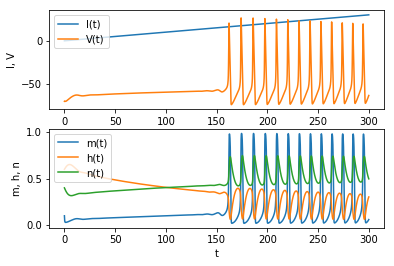

In [4]:
# run a simulation
tt = np.arange(0, 300, 0.1)  # time to be simulated
y0 = [ -70, 0.1, 0.6, 0.4]  # initial state: V, m, h, n
yt = odeint(hh, y0, tt, args=(ramp,))   # simulated output
# plot in separate rows
plt.subplot(2, 1, 1)
plt.plot(tt, ramp(tt));  # stim
plt.plot(tt, yt[:,0]);   # Ie, V
plt.ylabel("I, V");
plt.legend(("I(t)", "V(t)"), loc='upper left');
plt.subplot(2, 1, 2)
plt.plot(tt, yt[:,1:]);  # m, h, n
plt.xlabel("t")
plt.ylabel("m, h, n");
plt.legend(("m(t)", "h(t)", "n(t)"), loc='upper left');

### Integrate-and-fire neuron models

The HH model explaines why a spike is generataed and followed by a refractory period based on the activation and inactionvation of sodium and potassium channels.
We are, however, often interested in how a spike is triggered, rather than and electric mechanisms to create a spike. 

*Integrate-and-fire* (IaF) neurons models considers the dynamics of sub-threshold accumulation of input currents up to a spiking threshold, but take a spike as just an event and then reset the potential. From the HH equation, by removing the sodium and potassium current, we have

$$C \frac{dV(t)}{dt} = g_L(E_L-V(t)) + I$$

By defining the membrane resistance $R=\frac{1}{g_L}$ and the time constant $\tau=RC$, we have the equation of *leaky integration*

$$\tau\frac{dV(t)}{dt} = -V(t) + E_L + R I(t)$$

When the membrane potential $V$ reaches to a threhold $V_\theta$, a spike is generated and the membrane potential is reset to $V_r$.

$$V(t) = V_r  \quad\mbox{ if } V(t) \ge V_\theta$$

Below is an example of an IaF model. Here we use `ode()` function to detect reaching to the threshold by the `solout` option.

In [5]:
tau = 20
R = 1
El = -50  # resting potential
Vth = -40  # threshold
Vs = 40  # spike height
Vr = -80  # reset
def integ(t, v, stim=0.):  # integrate
    if callable(stim):
        I = stim(t)  # time-dependent
    else:
        I = stim  # constant
    return (-v + El + R*I)/tau
def fire(t, v):  # fire
    return (-1 if v>=Vth else 0)  # stop if v>=V1

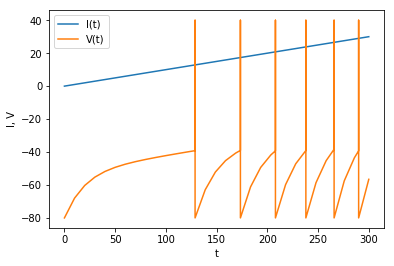

In [6]:
iaf = ode(integ)
iaf.set_integrator('dopri5')  # Runke-Kutta with step size control
iaf.set_solout(fire)  # stop when threshold is reached
iaf.set_initial_value(Vr, 0)
iaf.set_f_params(ramp)  # stimulus
V = [Vr]
T = [0]
tend = 300
dt = 10
while iaf.successful() and iaf.t <= tend:
    v = iaf.integrate(iaf.t+dt)  # step
    V.append(v)       # record V
    T.append(iaf.t)   # record t
    if v >= Vth:  # threshold reached
        iaf.set_initial_value(Vr, iaf.t)  # reset V
        V.append(Vs)  # spike
        T.append(iaf.t)
        V.append(Vr)  # reset
        T.append(iaf.t)
plt.plot(T, ramp(T))
plt.plot(T, V);
plt.xlabel("t")
plt.ylabel("I, V");
plt.legend(("I(t)", "V(t)"));

### F-I curve

In the HH or IaF models, as we increase the input current $I$, the spike firing frequency $F$ increases. It is possible to characterize the property of a neuron by this $F-I$ relationship.

In [7]:
def iafspikes(Ic):  # spike times with constant current
    iaf = ode(integ).set_integrator('dopri5')
    iaf.set_solout(fire)  # stop when threshold is reached
    iaf.set_f_params(Ic)  # stimulus
    iaf.set_initial_value(Vr, 0)
    tinit = 200  # initial transient
    trun = 1000  # for 1000ms
    dt = 1
    tf = []  # spike timing
    while iaf.successful() and iaf.t <= tinit+trun:
        v = iaf.integrate(iaf.t+dt)  # step
        if v >= Vth:  # threshold reached
            iaf.set_initial_value(Vr, iaf.t)  # reset V
            if iaf.t>=tinit:  # after transient
                tf.append(iaf.t)
    return np.array(tf)

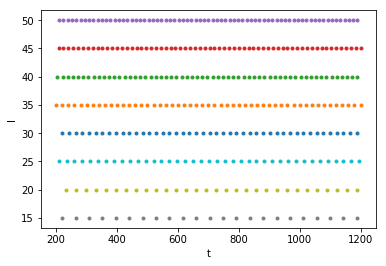

In [8]:
Is = np.arange(-20, 51, 5)
Fs = []
for c, Ic in enumerate(Is):
    tf = iafspikes(Ic)
    plt.plot(tf, tf*0+Ic, '.')
    Fs.append(len(tf))
plt.xlabel("t")
plt.ylabel("I");

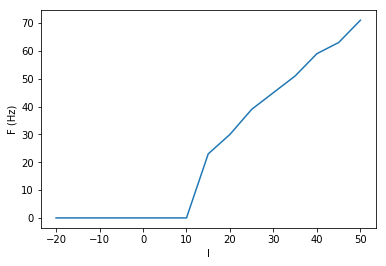

In [9]:
plt.plot(Is, Fs);
plt.xlabel("I")
plt.ylabel("F (Hz)");

### Noisy integrate-and-fire model
Try adding some noise to the neuron.

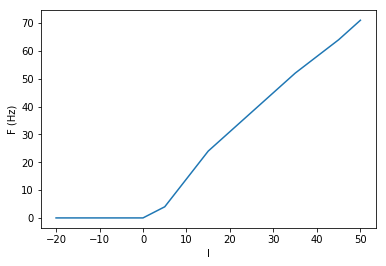

In [10]:
In = 20  # noise size
noise = np.random.normal(0, 1, 1500)  # normal gaussian noise every 1ms
def Inoise(t):
    i = int(np.floor(t))
    return Ic + In*noise[i]
Fs = []
for c, Ic in enumerate(Is):
    tf = iafspikes(Inoise)
    #plt.plot(tf, tf*0+c, '.')
    Fs.append(len(tf))
plt.plot(Is, Fs);
plt.xlabel("I")
plt.ylabel("F (Hz)");

The firing threshold becomes smoother with noise.

### Linear-nonlinear-Poisson models

In some mathematical analysis, it is convenient to assume that a neuron collects synaptic inputs by linear weighted sum, sets its firing rate through a nonlinear function taking non-negative values, such as exponential and sigmoid function, and produces spikes stochastically according to its instantaneous firing rate.

This is a *Poisson* process, for which the number of spiked generated in a time bin follows the Poisson distribution.

### Alpha function model of synaptic current

When a spike travels through an axon and reaches to a synpase, it causes release of neurotransmitter molecules in the synaptic junction, which binds to the receptors on the postsynapic membrane, and cause either opening of ionic channels of the receptor or trigger molecular reactions in the postsynaptic cell.

A simple model to approximate the dynamics of this complex cascades is the *alpha function*, defined as

$$u(t) = \frac{t}{\tau_s} e^{-\frac{t}{\tau_s}}$$

Text(0, 0.5, 'u(t)')

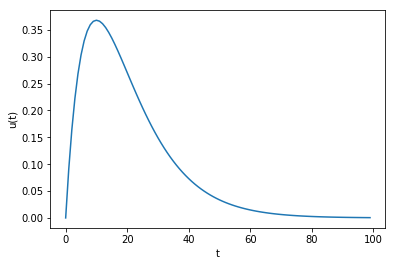

In [11]:
def alpha(t, taus):
    return t/taus*np.exp(-t/taus)
t = np.arange(0, 100, 1)
taus = 10
plt.plot(t, alpha(t, taus));
plt.xlabel("t")
plt.ylabel("u(t)")

The alpha function is a solution of a second-order dyamics to an impulse input at t=0

$$\tau_s\frac{du_1(t)}{dt} = -u_1(t) + \delta(t=0)$$

$$\tau_s\frac{du_2(t)}{dt} = -u_2(t) + u_1(t)$$

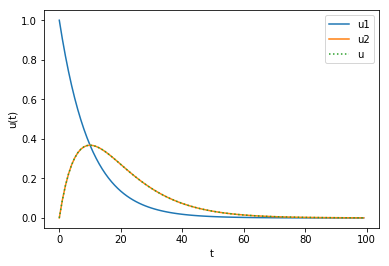

In [12]:
def falpha(u, t):
    # dynamics for alpha function. u = [u1, u2]
    return np.array([-u[0], u[0] - u[1]])/taus
ut = odeint(falpha, [1, 0], t)  # impulse input at t=0
plt.plot(t, ut)
plt.plot(t, alpha(t, taus), ':');  # analytic form in dotted line
plt.xlabel("t")
plt.ylabel("u(t)")
plt.legend(("u1", "u2", "u"));

Let us make a network of IaF neurons with alpha function synapses.

In [13]:
# IaF neuron network with alpha function synapses
#I = 0   # bias current
# Iaf neurons
N = 10  # number of neurons
tau = 50  # cellular time constant
V0 = -45  # resting near threshold
Vth = -40  # threshold
Vs = 40  # spike height
Vr = -80  # reset
# Alpha synapses
taus = 5  # synaptic time constant
W = 40   # connection weight size; assume exponential distribution
w = np.random.exponential(W, N**2).reshape((N,N))
for i in range(N):
    w[i,i] = 0  # remove self-connection

In [14]:
def integnet(t, vu):  # integrate
    # vu = [v, u]
    v = vu[:N]
    u = vu[N:].reshape((N,N,2))
    # synaptic potential
    epsp = np.sum(w*u[:,:,1], axis=1)  # sum rows
    # membrane dynamics
    dv = (-v + V0 + epsp)/tau
    # synaptic dynamics: for uniform taus, it can be reduced to N dim
    du = np.stack((-u[:,:,0]/taus, (u[:,:,0]-u[:,:,1])/taus), axis=2)
    return np.concatenate([dv, du.flatten()])
def firenet(t, vu):  # fire
    return (-1 if sum(vu[:N]>=Vth) else 0)  # stop if any of v>=V1

In [15]:
# Run a network simulation
iafnet = ode(integnet).set_integrator('dopri5')
iafnet.set_solout(firenet)  # stop when threshold is reached
v0 = np.random.uniform(Vr, Vth, N)  # initial state
u0 = np.random.uniform(0, 1, N*N*2)  # synapse state
iafnet.set_initial_value(np.append(v0, u0, 0))
V = [v0]
T = [0]
tend = 500
dt = 1
while iafnet.successful() and iafnet.t <= tend:
    vu = iafnet.integrate(iafnet.t+dt)  # new v and u
    V.append(vu[:N].copy())   # record V
    T.append(iafnet.t)    # record t
    if sum(vu[:N] >= Vth):  # any reached threshold
        for i in range(N):   # check each neuron
            if vu[i] >= Vth:  # reached threshold
                vu[i] = Vr   # reset potential
                vu[N:].reshape(N,N,2)[:,i,0] += 1  # synaptic input
                V[-1][i] = Vs  # spike
        iafnet.set_initial_value(vu, iafnet.t)  # reset state
V = np.array(V)   # list to array

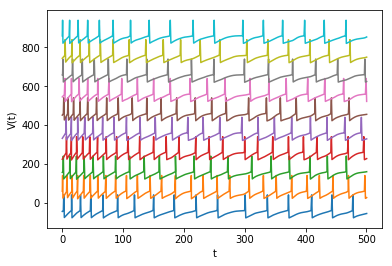

In [16]:
plt.plot(T, V + np.arange(N)*100);  # shift traces vertically
plt.xlabel("t")
plt.ylabel("V(t)");

### Cable equation and compartment models

(To be written)

## Abstract neuron models

### Mean-field models

In the invertebrate neuvous system with small number of neurons, each single neuron has a distinct identity and signals specifit information. 
In the mammarian brain with millons to billions of neurons, on the other hand, neural responses tend to be redundant and distributed. 
For example, in the visual cortex, neurons in the same *column* have similar sensory tuning, such as presentation of edges in the same orientation.
Moreover, responses of each neuron to the same stimulus can be variable across trials.
This suggest that information is reliably represented by a population of neurons sharing the same tuning.

*Mean-field* models, or neural *mass* model, capture the average firing rate of each population of neurons.

The activity of a population of $N$ neurons is defined as

$$A(t) = \lim_{\Delta t\rightarrow 0} \frac{n(t;t+\Delta t)}{N\Delta t}$$

where $n(t;t+\Delta t)$ is the number of spikes in the short time duration $\Delta t$.

For a population of identical IaF neurons with random homogeneous connections, the pupulation activity $A(t)$ and average membrane potential $h(t)$ can be apprximated by the following equations (Gerstner et al., 2014):

$$A(t) = F(h(t))$$

$$\tau \frac{dh(t)}{dt} = -h(t) + R I(t)$$

The gain function $F$ is often approximated by a sigmoid function

$$F(h) = \frac{1}{1 + e^{-a(h-\theta)}}$$

#### Wilson-Cowan model
A classic example of a mean-field model is the Wilson-Cowan model, which consists of excitatory and inhibitory populations connected to each other.
Depending on the connection strengths, we can observe point attractor or oscillating behaviors.

In [17]:
# Mean field network model
N = 2  # number of populations
w = np.array([[10, -10], [10, 0]])
theta = np.array([-2.5, 2.5])
tau = 10
def gain(h):
    h = np.array(h)  # to accept list input
    return 1/(1 + np.exp(-h))
def mfn(h, t):
    return (-h + np.dot(w, gain(h)) - theta)/tau

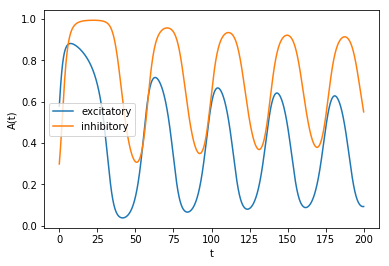

In [18]:
tt = np.arange(0, 200, 0.1)  # time to be simulated
h0 = np.random.uniform(-1, 1, N)  # initial state
ht = odeint(mfn, h0, tt)   # simulated output
plt.plot(tt, gain(ht));   # A(t) = F(h(t))
plt.xlabel("t")
plt.ylabel("A(t)")
plt.legend(("excitatory", "inhibitory"));

### Artificial neural network models

Abstraction of linear weighted input and nonlinear gain function from those neuraon models brings us to *artificial neural networks* or *connectionist models*.

$$x_i(t+1) = \sum_{j=1}^n w_{ij} f(x_j(t))$$

This is a recurrent neural network. 

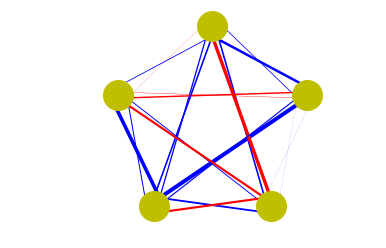

In [19]:
# Illustration of a recurrent neural network
n = 5  # number of neurons
W = np.random.normal(0, 1, n*n).reshape(n,n)  # random weights
i = np.arange(0,n)  # neuron index
pos = np.array([np.sin(2*np.pi*i/n), np.cos(2*np.pi*i/n)]).T
for i in range(n):  # target
    for j in range(n):  # source
        # edges from sources shifted inside, to target outside
        plt.plot(pos[[j,i],0]*[.9,1.1], pos[[j,i],1]*[.9,1.1],
                 lw=2*abs(W[i,j]), color=('r' if W[i,j]>0 else 'b'))
plt.plot(pos[:,0], pos[:,1], 'oy', markersize=30)
plt.axis('equal')
plt.axis('off');

### Feed-forward neural networks

A popular sub-class of artificial neural networks is *feed-forward* networks, which are organized by multiple layers and connections are uni-directional from lower to upper layers.

$$x_i^{l+1} = \sum_{j=1}^n w_{ij}^l f(x_j^l)$$

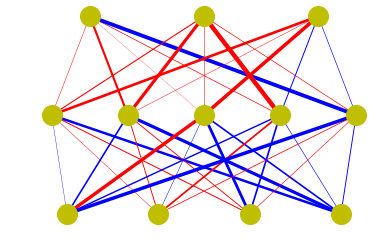

In [20]:
# Illustration of a feed-forward neural network
n = [4, 5, 3]  # numbers of neurons in layers
W = []  # empty list
for l in range(len(n)-1):  # weights from bottom to top layers
    W.append(np.random.normal(0, 1, n[l+1]*n[l]).reshape(n[l+1],n[l]))
    for i in range(n[l+1]):  # target
        for j in range(n[l]):  # source
            plt.plot([(j+1)/(n[l]+1), (i+1)/(n[l+1]+1)], [l, l+1],
                 lw=2*abs(W[l][i,j]), color=('r' if W[l][i,j]>0 else 'b'))
    plt.plot((np.arange(n[l])+1)/(n[l]+1), np.repeat(l,n[l]), 'oy', markersize=20)
plt.plot((np.arange(n[-1])+1)/(n[-1]+1), np.repeat(len(n)-1,n[-1]), 'oy', markersize=20)
plt.axis('off');

#### Activation functions: Sigmoid, ReLU, and binary

As the activation (or gain) function $f$, the most popular one is the (logistic) sigmoid function.

$$f(x) = \frac{1}{1 + e^{-x}}$$

The use of *rectified linear unit* (ReLU) is also becoming popular for deep layered networks.

$$f(x) = \max(x, 0)$$

The classic McCulloch-Pitts model took a binary activation function.

$$f(x) = \begin{cases} 1 & \mbox{if } x \ge 0 \\ 0 & \mbox{if } x<0 \end{cases}$$

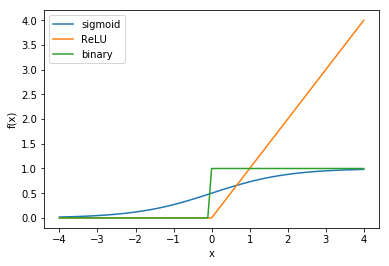

In [21]:
# Activation functions
def sigmoid(x):
    return 1/(1+np.exp(-x))
def relu(x):
    return np.maximum(x, 0)
def binary(x):
    return x>=0
x = np.arange(-4, 4.1, 0.1)
plt.plot(x, sigmoid(x))
plt.plot(x, relu(x))
plt.plot(x, binary(x))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(("sigmoid", "ReLU", "binary"));

### Softmax function
For a layer where proabailistic intertretation is desired, *softmax* function whose sum over all units is one.

$$f_i(x) = \frac{e^{x_i}}{\sum_j e^{x_j}}$$

In [22]:
# Softmax function
def softmax(x, beta=1):
    """softmax function: x is a vector, or column vectors"""
    ex = np.exp(beta*np.array(x))
    # return ex/np.sum(ex)   # for one vector
    return ex/np.sum(ex, axis=0)  # for column vectors

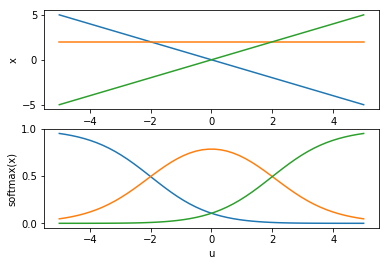

In [23]:
u = np.linspace(-5, 5)
x = np.stack( (-u, u*0+2, u))  # three components
plt.subplot(2, 1, 1)
plt.plot(u, x.T)
plt.ylabel("x");
plt.subplot(2, 1, 2)
plt.plot(u, softmax(x).T)   # constrained in [0, 1]
plt.xlabel("u")
plt.ylabel("softmax(x)");

## Models of plasticity

### Hebb rule
"Cells fire together wire together" is the basic concept proposed by Donald Hebb [Hebb1952]. More specifically, the Hebbian synaptic plasticity rule takes the form

$$\Delta w_{ij}(t) = \alpha y_i(t) y_j(t)$$
where $\alpha$ is the learning rate parameter.

### Spike timining dependent placticity (STDP)
It has been observed in hippocampus, cortex and other networks that synaptic plasiticity is dependent on the timing of pre- and post-synapic spikes.

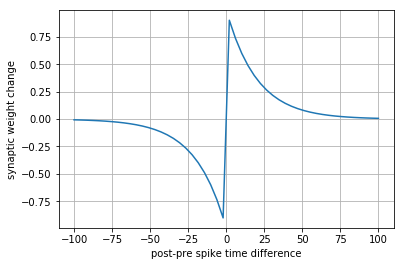

In [24]:
t = np.linspace(-100, 100)  # post-pre spike time difference
tau = 20  # time constant
dw = (t<0)*(-np.exp(t/tau)) + (t>0)*np.exp(-t/tau)  # depression if t<0
plt.plot(t, dw)
plt.grid(True)
plt.xlabel("post-pre spike time difference")
plt.ylabel("synaptic weight change");

## Theories of neural coding

It is certain that neurons carry sensory, motor, or any cognitive information and perform computation by combining and transforming such information.
But how exectly do they code a variety of information? 
This is not a trivial problem and there are many theories and debates.

### Rate coding
Each neuron encodes a certain variable by its firing rate. This is most evident in sensory receptor neurons and motor neurons.
For example, the firing rate of a retinal photoreceptor is monotinically related to the strength of the light hitting the cell.

### Population coding
For motor control and cognitive processing, the brain has to combine multiple modalities of information, such as vision, hearing, touch and proprioception.
To represent particular combinations of such information, some kind of multi-dimensional non-linear basis functions are required.

*Population coding* is an idea in which a group of neurons with different response tuning functions represent information by their activity patterns.
The recepient neurons can extract specific information by weighted sum of their activities.

### Temporal coding
In the rate coding framework, what matters is the frequency of spikes of neurons coding the same or related information.
But there is a possiblity that not just the frequency, but the timing of each spike carry a certain information.

For example, it is known that spikes of some auditory neurons are produced a certain phase of sound wave, which can be helpful for identification of sound source direction by detecting the time difference of the sound arriving in left and right ears.

A more sophisticated idea is that even at the same firing frequencies, neurons represent related information by the synchrony of spikes.
Experimental evidence suggests that visual cortex neurons that respond to line segments in a similar orientation spike synchronously for a single connected line, but asynchronously for separate line segments.

![Gray89](figures/gray89.jpg)
Top: responses of two visual cortex neurons to separate and continuous lines.  
Bottom: the spike correlograms of the two neurons. From Gray et al. (1989).

## Methods for spike analysis/decoding

### Peristimulus time histogram (PSTH)
A neuron's repsonse to the same sensory stimulus can vary trial-by-trial.
While primary sensory neurons respond reliably to sensory stimuli, sensory responses of cortical neurons are known to be highly variable across trials.

To characterize the average response properties of a neuron, the most typical method is to align the spike trains from different trials at the stimulus onset and count the number of spikes in time bins of tens to hundreds of milliseconds.
The original spike trains in multiple trials are often called *raster plot* and the average spike frequency around the time of stimulus onset is called *peristimulus time histogram (PSTH)*.

![Schultz97](figures/Schultz97.jpg)
The PSTH and raster plots of a midbrain dopamine neuron's response to a visual stimulus followed by a juice reward after 1 second. From Schultz et al. (1997).

### Spike-triggered average (STA)
Charactering the response property of a neuron the other way round it to see what happened before a spike is generated.
That is *spike-triggered average (STA)* of sensory stimuli.

![Ohzawa97](figures/Ohzawa97.jpg)
Spike-triggered average of random-dot visual stimuli of a motion-sensitive visual cortex neuron shows its spatio-temporal response property. From Ohzawa et al. (1997).

## References

### Neurons models

* Hodgkin AL, Huxley AF (1952) A quantitative description of membrane current and its application to conduction and excitation in nerve. J. Physiol, 117(4):500–544.

* Gerstner W, Kistler WM, Naud R, Paninski L (2014) Neuronal Dynamics: From Single Neurons to Networks and Models of Cognition. [Cambridge University Press](https://www.cambridge.org/core/books/neuronal-dynamics/75375090046733765596191E23B2959D). 
([online version and Python exercise](http://neuronaldynamics.epfl.ch/))

* Wilson HR, Cowan JD (1972) Excitatory and inhibitory interactions in localized populations of model neurons. Biophys. J., 12:1–24.

### Neural coding and analysis

* Dayan P, Abott LF (2001) Theoretical Neuroscience: Compuational and
Mathematical Modeling of Neural Systems. MIT Press.

* Gray CM, Konig P, Engel AK, Singer W (1989) Oscillatory responses in cat visual cortex exhibit inter-columnar synchronization which reflects global stimulus properties. Nature, 338:334–337.

* Schultz W, Dayan P, Montague PR (1997) A neural substrate of prediction and reward. Science, 275:1593–1599.

* Ohzawa I, DeAngelis GC, Freeman RD (1997) The neural coding of
stereoscopic depth. Neuroreport, 8:3–12.

## Exercise

1) Draw the F-I curve for the H-H model.

2) Run a network of IF neurons with simple pulse-connection instead of $\alpha$ function.

3) Simulate an artificial recurrent neural network and see the behaviors with different connection weights.

4) Implement Hebbian or STDP rule in the above network model and see how the network behavior and weights evolve with plasticity. 